# ARIMA PREDICTION

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno
import os, warnings, gc
import scipy.stats as stats
import random
seed = 4092
random.seed(seed)
np.random.seed(seed)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings('ignore')

#Time series libraries
from scipy import stats
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import pacf, plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import  ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
%matplotlib inline

### LOADING AND VERIFYING DATA:

In [22]:
df = pd.read_csv(os.getcwd()+"/pre_processing/dataset_traite.csv", sep=',',index_col=['DateTime'])
df.index = pd.to_datetime(df.index)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [24]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [25]:
df.shape

(2075259, 7)

### CORRELATION BETWEEN LAG VARIABLES AND OUTPUT VARIABLE (GLOBAL_ACTIVE_POWER):

### Lets resample our dataset day by day

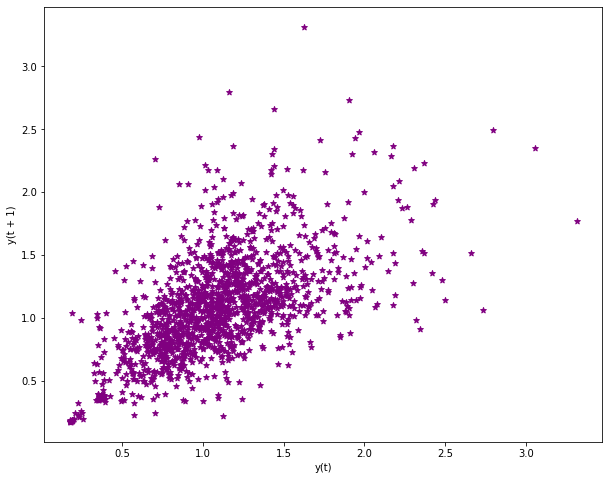

In [26]:
lagplot_data = df['Global_active_power'].resample('D').mean()
plt.figure(figsize = (10,8))
lagplot = lag_plot(lagplot_data, c = 'purple', marker = '*')
plt.show()

#### The lag plot shows the variables at time t on the x axis, and variables at time t+1 on the y axis.
#### So if the lagplot shows some form of correlation, like a line or a curve, we can say that the plot shows some form of correlation betwwen present and future time for the variables of the dataset.
#### Here we plotted only Global Active Power, so we can say that the value of Global active power at t+1 is correlated to the value at t, therefor it might be predictable

In [27]:
lagplot_data_df = pd.concat([lagplot_data.shift(-1), lagplot_data], axis = 1)
lagplot_data_df.columns = ['Global_active_power(t)', 'Global_active_power(t+1)']
lagplot_data_corr = lagplot_data_df.corr()
lagplot_data_corr

,Global_active_power(t),Global_active_power(t+1)
Global_active_power(t),1.000000,0.609208
Global_active_power(t+1),0.609208,1.000000


#### The correlation matrix above that global active power at time t and at tiem t+1 are correlated at 61%

### Lets resample the dataset again but week by week

In [28]:
df1 = df['Global_active_power'].resample('W').mean()
lagplot_data1 = df1.copy()

#### Lets plot an autocorrelation plot of the data per week

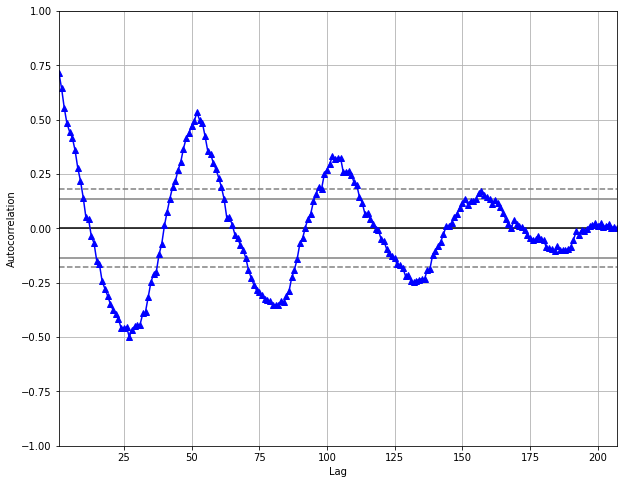

In [29]:
plt.figure(figsize = (10,8))
lagplot1 = autocorrelation_plot(lagplot_data1, c = 'blue', marker = '^')
lagplot1.plot(title = 'Autocorrelation Plot of the Data resampled over Hour')
plt.show()

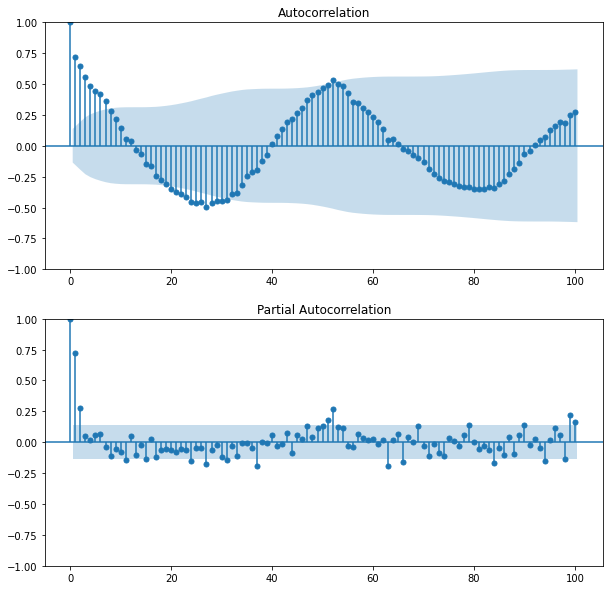

In [30]:
# plots
plt.figure(figsize = (10,10))
lags = 100
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(df1, ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(df1, ax=axis, lags=lags)
# show plot
plt.show()

##### PAC shows a significant value on lag of 1, and AC shows a period trend of 52 weeks, also visible on the PACF plot in a certain measure. For ARIMA/SARIMA model, we should use p=q=1 with 52 seasonal

In [31]:
df_to_scale = df['Global_active_power'].resample('W').agg('mean').values.reshape(-1,1)
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(df_to_scale)
len(scaled_data)

207

#### AR MODEL (auto regressive):

Test Mean Squred Error: 0.07136
Test Root Mean Squred Error: 0.26714


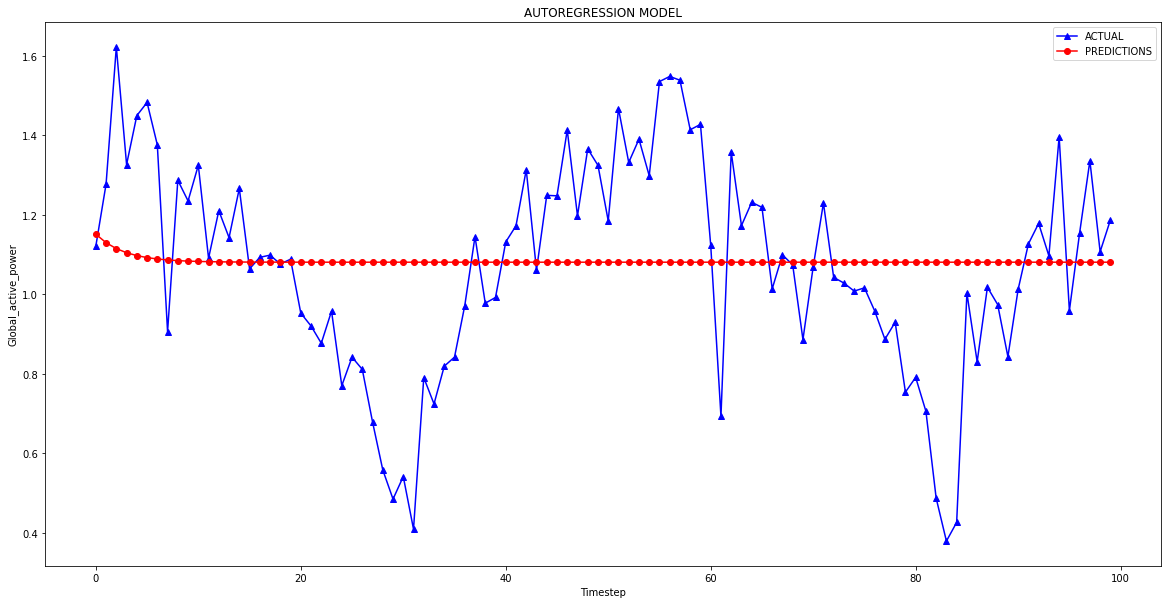

'=======AUTOREGRESSION  DONE======='

In [46]:
def ar_model(dataset):
    X = dataset
    train, test = X[:len(X)-100], X[len(X)-100:]
    
    autoreg = AutoReg(train, lags = 1)
    autoreg_fit = autoreg.fit()
    #print(autoreg_fit.summary())

    predictions = autoreg.predict(autoreg_fit.params, start = len(train), end = len(train)+len(test)-1, dynamic = True)


    test = scaler.inverse_transform(test)
    predictions = scaler.inverse_transform([predictions])
    MSE = mean_squared_error(test, predictions[0])
    RMSE = np.sqrt(MSE)
    print("Test Mean Squred Error: %0.5f" % MSE)
    print("Test Root Mean Squred Error: %0.5f" % RMSE)
    plt.figure(figsize=(20,10))
    plt.plot(test, color = 'blue',marker = '^', label = 'ACTUAL')
    plt.plot(predictions[0], color='red', marker = 'o', label = 'PREDICTIONS')
    plt.title("AUTOREGRESSION MODEL")
    plt.xlabel('Timestep')
    plt.ylabel('Global_active_power')
    plt.legend()
    plt.show()
    return '=======AUTOREGRESSION  DONE======='

ar_model(scaled_data)

#### ARIMA MODEL (auto regressive integrated moving average):

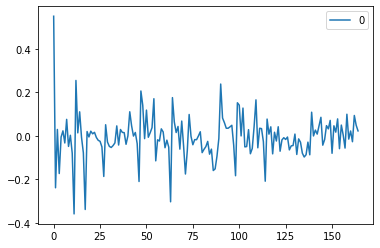

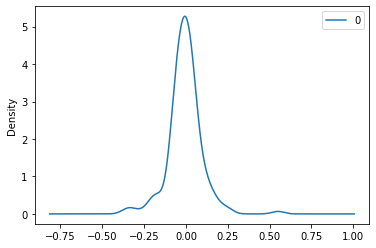

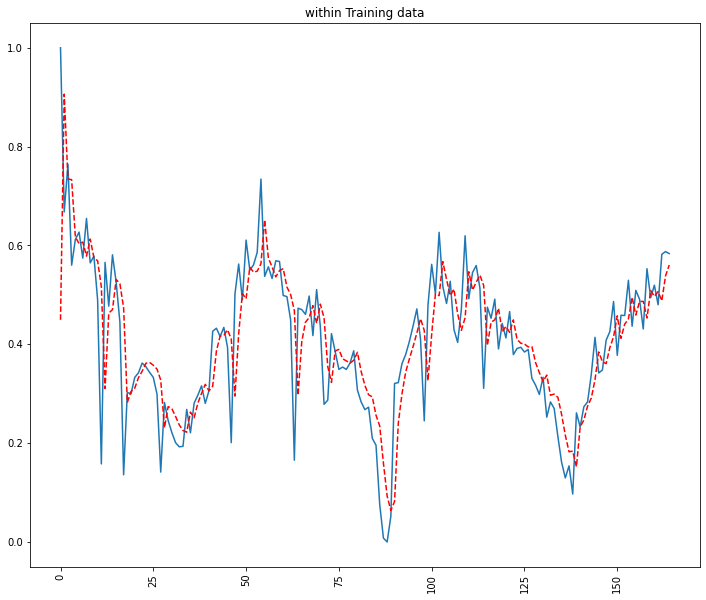

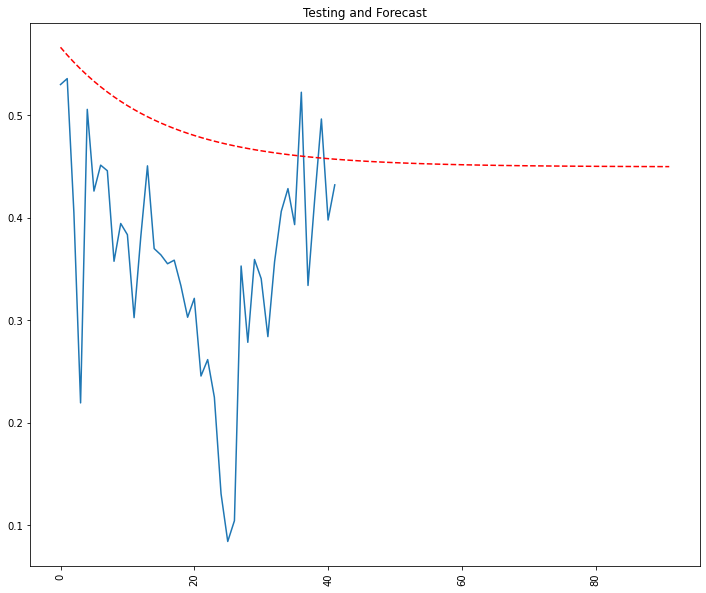

RMSE in Testing Data: 0.1643416935542502


In [17]:
def arima_model(dataset):
   
    train_size = int(0.8*(len(dataset)))
    test_size = len(dataset)-train_size
    train, test = dataset[:train_size], dataset[train_size:len(dataset)]

    train_data = [x for x in train]
    predictions = list()
    y_test = list()

    model = ARIMA(train_data, order=(1,0,1))
    model_fit = model.fit()

    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    residuals.plot(kind='kde')
    plt.show()
    
    in_sample_forecast =model_fit.predict() #cut first value since it start value is 0
    out_sample_forecast = model_fit.get_forecast(test_size+50, alpha = 0.4)
    plt.figure(figsize=(12,10))
    plt.plot(dataset[:train_size])
    plt.plot(in_sample_forecast, color='red',linestyle='dashed')
    plt.xticks(rotation='vertical')
    plt.title('within Training data')
    plt.show()
    plt.figure(figsize=(12,10))
    plt.plot(dataset[train_size:len(dataset)])
    plt.plot(out_sample_forecast.predicted_mean, color='red',linestyle='dashed')
    #plt.plot(out_sample_forecast.conf_int()['lower Global_active_power'], color='green',linestyle='dashed')
    #plt.plot(out_sample_forecast.conf_int()['upper Global_active_power'], color='green',linestyle='dashed')
    plt.xticks(rotation='vertical')
    plt.title('Testing and Forecast')
    plt.show()


    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import explained_variance_score
    MSE = mean_squared_error(y_true = np.array(dataset[train_size:len(dataset)]), y_pred = out_sample_forecast.predicted_mean[:test_size])
    print('RMSE in Testing Data:' , MSE**(0.5))

arima_model(scaled_data)

##### This model fails to predict values of the testing set, as well as forecasting future values.
##### Its incapacity to predict correct values might be link to its lack of seasonal information, which we will add in the next model.

#### SARIMA MODEL (seasonal auto regressive integrated moving average):

#### In this model, we will introduce the seasonal pattern of 52 weeks discovered with the AC and PAC plots

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39909D+00    |proj g|=  8.72945D+01


 This problem is unconstrained.



At iterate    5    f= -1.75417D-01    |proj g|=  2.61063D+00

At iterate   10    f= -2.47211D-01    |proj g|=  1.27675D+00

At iterate   15    f= -2.57352D-01    |proj g|=  2.23921D-01

At iterate   20    f= -2.74438D-01    |proj g|=  2.04804D+00

At iterate   25    f= -3.73215D-01    |proj g|=  5.94935D-01

At iterate   30    f= -3.80508D-01    |proj g|=  8.14360D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     56      1     0     0   6.475D-04  -3.805D-01
  F = -0.38050875929471539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


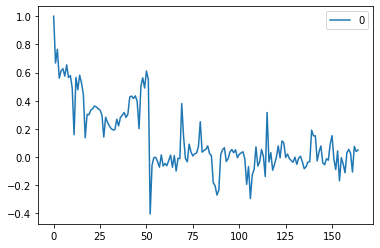

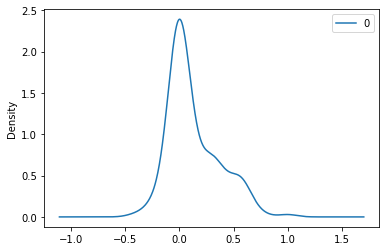

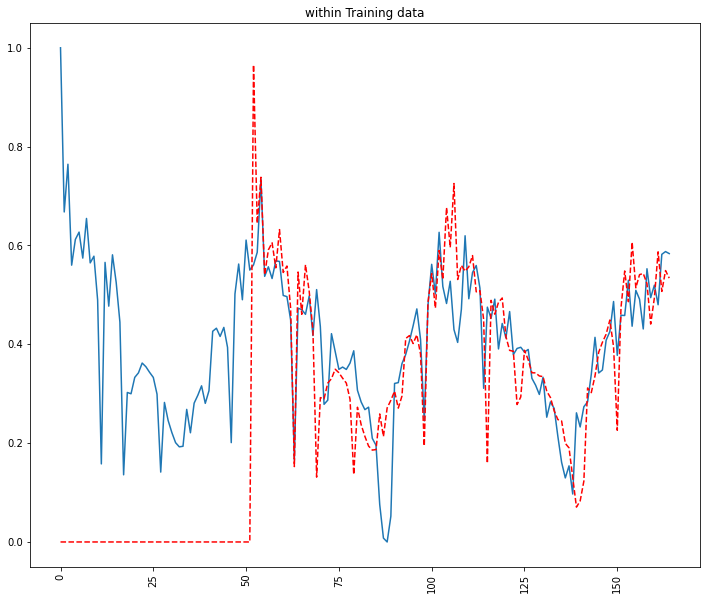

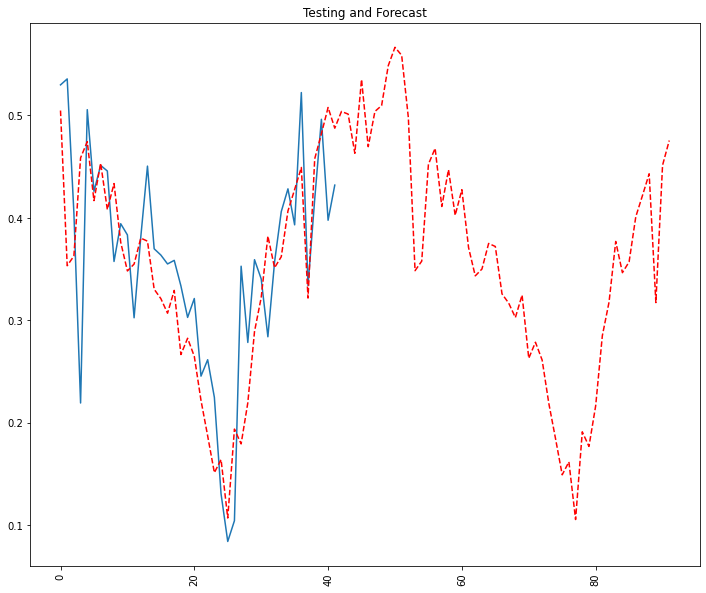

RMSE in Testing Data: 0.07258074529069655


In [18]:
def arima_model(dataset):
   
    train_size = int(0.8*(len(dataset)))
    test_size = len(dataset)-train_size
    train, test = dataset[:train_size], dataset[train_size:len(dataset)]

    train_data = [x for x in train]
    predictions = list()
    y_test = list()

    model = SARIMAX(train_data, order=(0,0,0),seasonal_order = (1,0,1,52))
    model_fit = model.fit()

    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()
    residuals.plot(kind='kde')
    plt.show()
    
    in_sample_forecast =model_fit.predict() #cut first value since it start value is 0
    out_sample_forecast = model_fit.get_forecast(test_size+50, alpha = 0.4)
    plt.figure(figsize=(12,10))
    plt.plot(dataset[:train_size])
    plt.plot(in_sample_forecast, color='red',linestyle='dashed')
    plt.xticks(rotation='vertical')
    plt.title('within Training data')
    plt.show()
    plt.figure(figsize=(12,10))
    plt.plot(dataset[train_size:len(dataset)])
    plt.plot(out_sample_forecast.predicted_mean, color='red',linestyle='dashed')
    #plt.plot(out_sample_forecast.conf_int()['lower Global_active_power'], color='green',linestyle='dashed')
    #plt.plot(out_sample_forecast.conf_int()['upper Global_active_power'], color='green',linestyle='dashed')
    plt.xticks(rotation='vertical')
    plt.title('Testing and Forecast')
    plt.show()


    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import explained_variance_score
    MSE = mean_squared_error(y_true = np.array(dataset[train_size:len(dataset)]), y_pred = out_sample_forecast.predicted_mean[:test_size])
    print('RMSE in Testing Data:' , MSE**(0.5))

arima_model(scaled_data)

##### This model does a surprisingly accurate job on the testing set, and the results of the forecasting really encapsulate the seasonal pattern present on the data, giving us similar results as the ones visible in past years (used for training and testing)